# Steady state 2D Navier Stokes Equations

In [2]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# Computation domain
Boundary condition at entry is velocity = u_in, at the walls is u = 0 (non-slip condition), and at the exit is constant pressure, P.

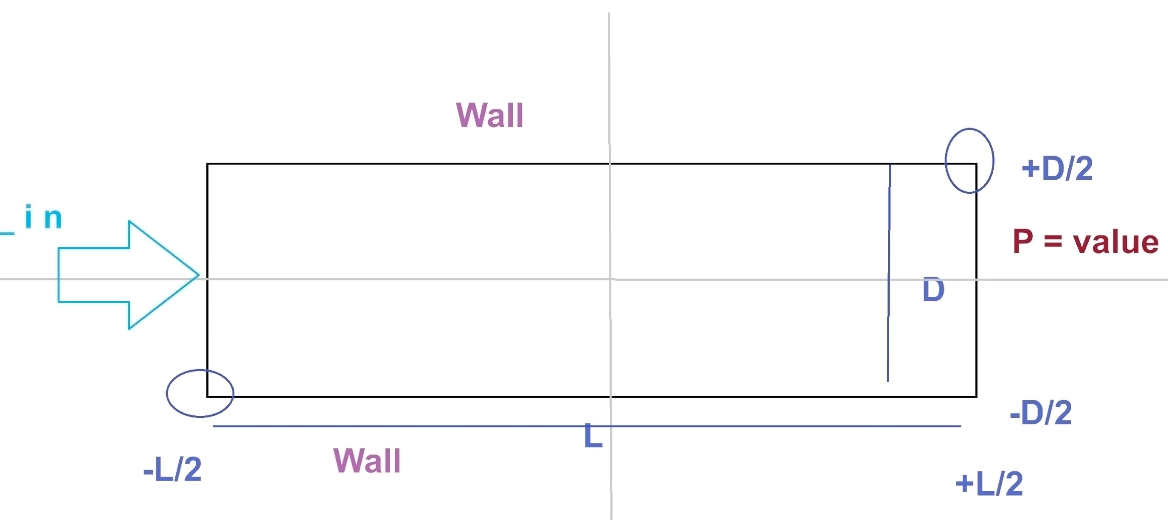

In [4]:
rho=1
mu=1
u_in=1
D=1
L=2

In [6]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

In [8]:
def boundary_wall(X, on_boundary):
    #print("X-coordinates: ", X)
    #print("Is boundary point?: ", on_boundary)
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1],-D/2, rtol=1e-05, atol=1e-08), np.isclose(X[1],D/2, rtol=1e-05, atol=1e-08)), on_boundary) #X[1] gives the y-coordinates which locate the walls
    return on_wall

def boundary_inlet(X, on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0], -L/2, rtol=1e-05, atol=1e-08), on_boundary) #x-cooridinate -L/2 is the entry
    return on_inlet

def boundary_outlet(X, on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0], L/2, rtol=1e-05, atol=1e-08), on_boundary) #x-cooridinate -L/2 is the entry
    return on_outlet

In [10]:
#Component #0 = u; Component #1 = v; Component #2 = p;

bc_wall_u = dde.DirichletBC(geom, lambda X:0., boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X:0., boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X:u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X:0., boundary_inlet, component=1) # y-component of velocity is 0 m/s

bc_outlet_v = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component=1) # y-component of velocity is 0 m/s
bc_outlet_p = dde.DirichletBC(geom, lambda X:0., boundary_outlet, component=2)


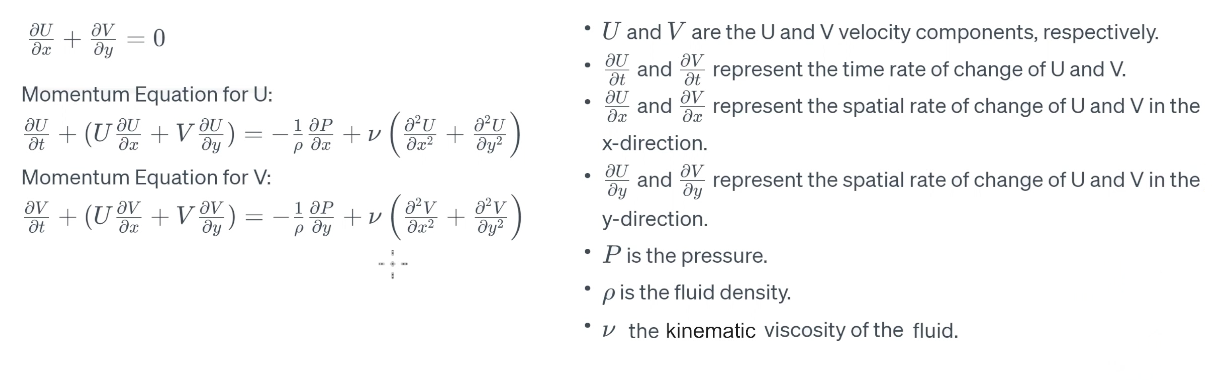

In [12]:
def pde(X,Y): 
    
    """
    This is the governing partial differential equations of the flow field.
    X contains the independent variables, i.e. spatial and temporal for unsteady state only spatial for steady state.
    Y contains the dependent variables, i.e. u, v & p.
    i & j allow indexing the components of the two input arrays in the Jacobian and Hessian, eg. u is an independent variable found as the first component in Y.
    """
    
    du_dx = dde.grad.jacobian(Y, X, i=0, j=0)
    du_dy = dde.grad.jacobian(Y, X, i=0, j=1)
    
    dv_dx = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_dy = dde.grad.jacobian(Y, X, i=1, j=1)
    
    dp_dx = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_dy = dde.grad.jacobian(Y, X, i=2, j=1)
    
    du_dxx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_dyy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_dxx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_dyy = dde.grad.hessian(Y, X, component=1, i=1, j=1)
    
    pde_u = (Y[:, 0:1] * du_dx) + (Y[:, 1:2] * du_dy) + (1/rho * dp_dx) - (mu/rho)*(du_dxx+du_dyy)
    pde_v = (Y[:, 0:1] * dv_dx) + (Y[:, 1:2] * dv_dy) + (1/rho * dp_dy) - (mu/rho)*(dv_dxx+dv_dyy)
    pde_const = du_dx + dv_dy
    pde_arr = [pde_u, pde_v, pde_const]
    return pde_arr

In [14]:
data = dde.data.PDE(geom,
                   pde,
                   [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_v, bc_outlet_p],
                   num_domain = 2000,
                   num_boundary = 200,
                   num_test = 200)

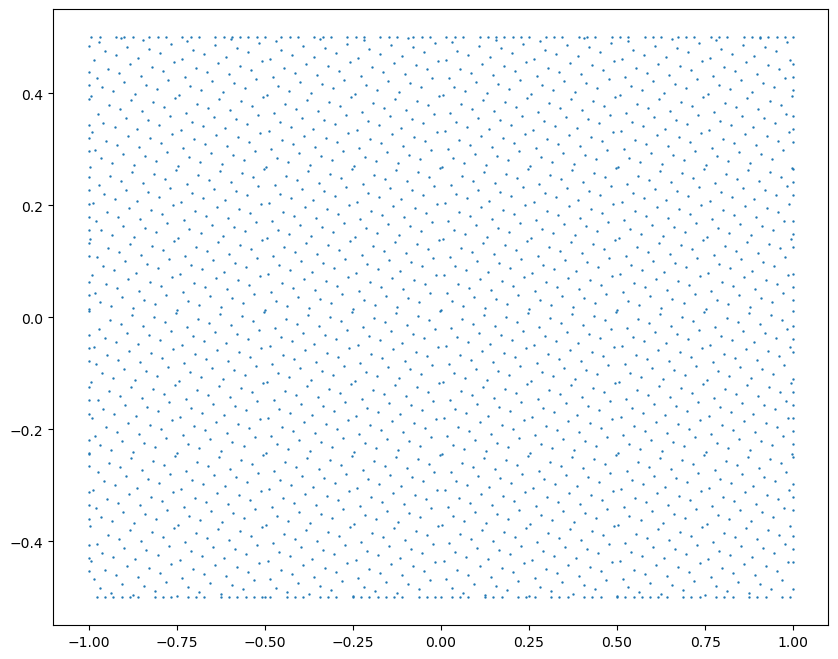

In [16]:
plt.figure(figsize=(10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s=0.5)
plt.show()

In [18]:
net = dde.maps.FNN([2] + [64]*5 + [3], "tanh", "Glorot uniform") #2x input nodes; 5x hidden layers with 64x nodes; 3x output nodes

In [20]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.611137 s



In [22]:
losshistory, train_state = model.train(epochs=10000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.09e-02, 3.97e-02, 1.25e-02, 5.31e-02, 4.03e-02, 1.39e+00, 7.10e-02, 6.92e-02, 2.66e-03]    [8.82e-03, 3.86e-02, 1.28e-02, 5.31e-02, 4.03e-02, 1.39e+00, 7.10e-02, 6.92e-02, 2.66e-03]    []  
1000      [7.90e-03, 6.91e-04, 6.15e-03, 2.72e-02, 1.41e-02, 3.91e-02, 1.42e-03, 5.39e-05, 2.08e-03]    [8.04e-03, 5.16e-04, 3.74e-03, 2.72e-02, 1.41e-02, 3.91e-02, 1.42e-03, 5.39e-05, 2.08e-03]    []  
2000      [8.06e-04, 7.83e-04, 4.40e-03, 2.14e-02, 1.12e-02, 3.05e-02, 6.33e-04, 2.17e-05, 8.22e-05]    [4.38e-04, 4.28e-04, 2.35e-03, 2.14e-02, 1.12e-02, 3.05e-02, 6.33e-04, 2.17e-05, 8.22e-05]    []  
3000      [7.01e-04, 5.39e-04, 3.69e-03, 1.90e-02, 9.62e-03, 2.45e-02, 1.75e-03, 6.84e-06, 5.06e-05]    [3.16e-04, 2.86e-04, 1.82e-03, 1.90e-02, 9.62e-03, 2.45e-0

In [24]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
'compile' took 0.002744 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [8.67e-04, 3.73e-04, 2.26e-03, 1.47e-02, 5.84e-03, 1.40e-02, 5.49e-03, 1.56e-05, 5.67e-05]    [5.24e-04, 2.35e-04, 9.12e-04, 1.47e-02, 5.84e-03, 1.40e-02, 5.49e-03, 1.56e-05, 5.67e-05]    []  
11000     [6.66e-04, 6.88e-04, 9.86e-04, 7.08e-03, 1.05e-03, 5.97e-03, 1.94e-03, 9.08e-06, 3.06e-05]    [3.72e-04, 3.81e-04, 5.51e-04, 7.08e-03, 1.05e-03, 5.97e-03, 1.94e-03, 9.08e-06, 3.06e-05]    []  
12000     [3.12e-04, 3.64e-04, 5.38e-04, 4.47e-03, 8.51e-04, 4.16e-03, 1.40e-03, 1.27e-06, 2.51e-05]    [1.98e-04, 2.17e-04, 2.43e-04, 4.47e-03, 8.51e-04, 4.16e-03, 1.40e-03, 1.27e-06, 2.51e-05]    []  
13000     [3.80e-04, 4.00e-04, 4.65e-04, 3.19e-03, 8.52e-04, 2.97e-03, 9.32e-04, 2.03e-06, 3.27e-06]    [1.41e-04, 2

In [30]:
model.save("PINNs_trained_models")

'PINNs_trained_models-13000.pt'

# Restore the trained model
Ensure data, boundary conditions and net are made available again,
i.e data, bc & net

# Create a new model instance
model = dde.Model(data, net)

model.restore("PINNs_trained_models-13000.pt", verbose=1)

In [26]:
samples = geom.random_points(500000)
result = model.predict(samples)

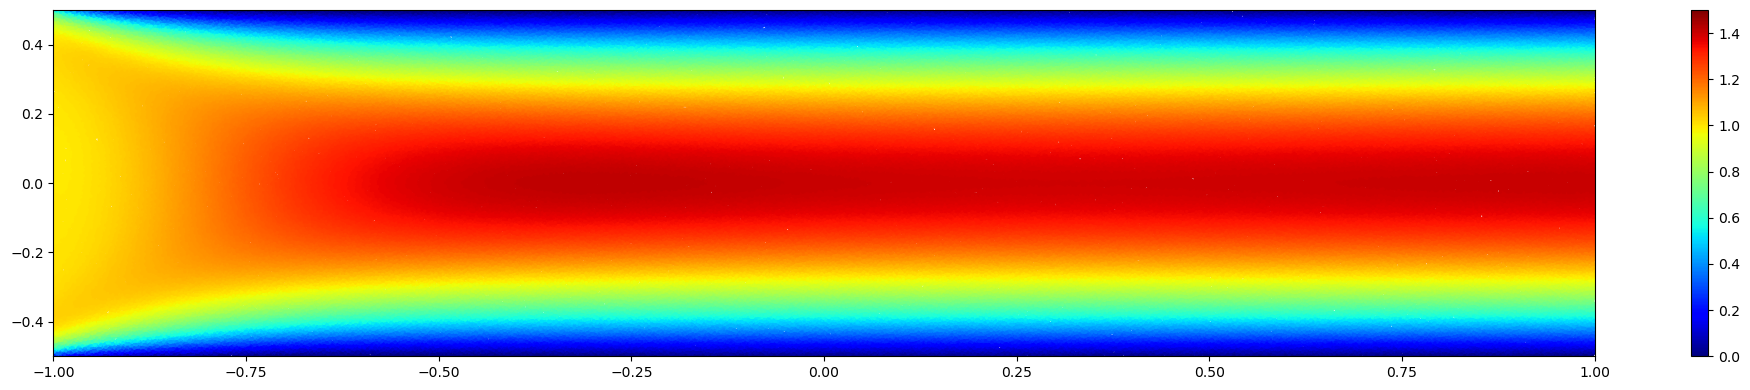

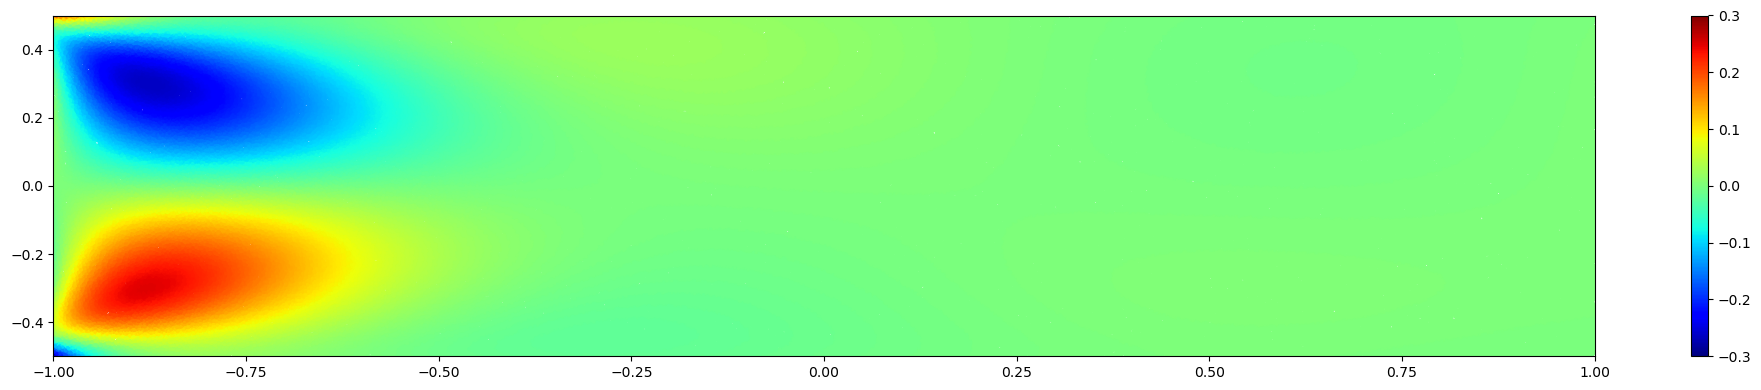

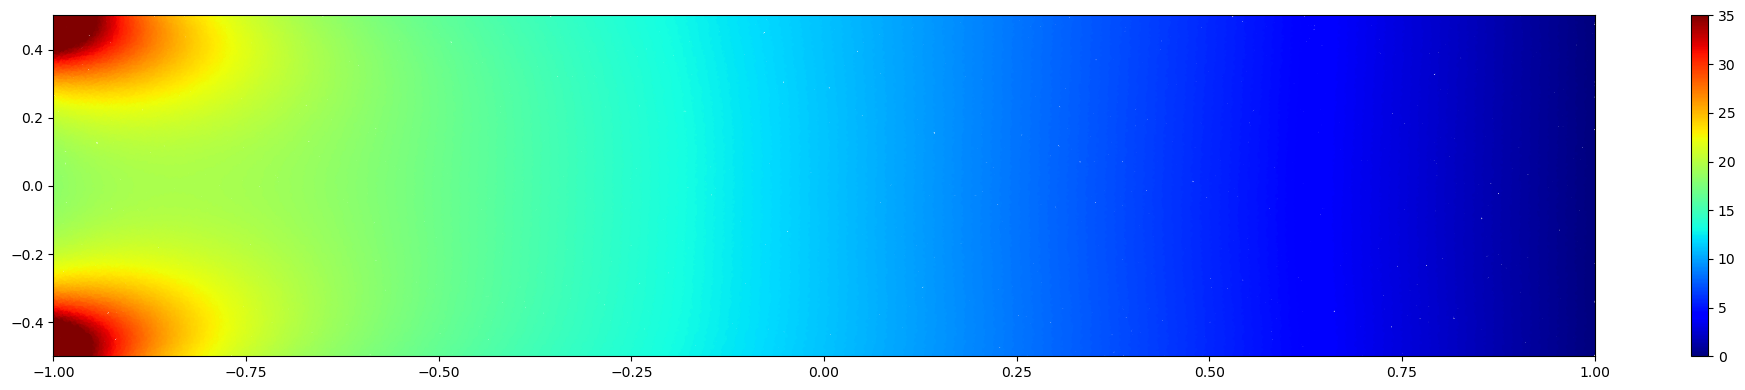

In [28]:
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:, 0],
    samples[:,1],
    c=result[:, idx],
    cmap='jet',
    s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()